# Example 3 - Calculating the grain boundary resistivity and activation energy

**Running the code in this notebook (under Mott-Schottky conditions for the 6 defined temperatures) takes approximately 3 minutes (iMac with 4 Ghz i7 processor).**

The resistivity ratio has been calculated for the system where defects are specific to their sites, there is a site with two positively charged defects, followed by two sites which each have one negatively charged defect. The central positively charged defects have a segregation energy of -1.0 eV and the negatively charged defects are fixed to their bulk mole fractions under the Mott-Schottky approximation. The figure below shows the grain boundary resistivity for the system at a range of temperatures between 773.15 K and 1273.15 K. The resistivity decreases as temperature increases as expected.  

The function to calculate the resistivity ratio takes two arguments. The first argument is whether the space charge potential is positive or negative, and the second argument is a limit for the potential to cut off the sites included in the calculation when the potential is less than or greater than the limit.
```
c_o.calculate_resistivity_ratio_new('positive', -4e-2)
```

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.set_up_calculation import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'periodic'
site_charges = False
systems = 'mott-schottky'
core_models = False
site_models = 'site_explicit'

In [3]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.0e-8
grid_x_max = +2.0e-8
bulk_x_min = -2.0e-8
bulk_x_max = -1.0e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]

In [4]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]
initial_guess = [ [ 0.2, 0.2 ] ]
mobilities = [ 1.0, 1.0 ]

In [5]:
data = '../input_data/example_data_2_one_seg_energies.txt'

In [6]:
par_resistivity_ratio_list = []
per_resistivity_ratio_list = []

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        
        per_resistivity_ratio_list.append(c_o.perpendicular_resistivity_ratio)
        par_resistivity_ratio_list.append(c_o.parallel_resistivity_ratio)


--- 165.04243683815002 seconds ---


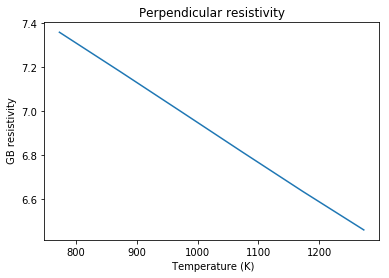

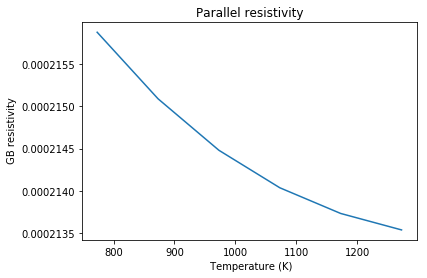

In [7]:
plt.plot( temp, per_resistivity_ratio_list)
plt.title('Perpendicular resistivity')
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' GB resistivity' )
plt.show()

plt.plot( temp, par_resistivity_ratio_list)
plt.title('Parallel resistivity')
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' GB resistivity' )
plt.show()

The activation energy can then be calculated from the Arrhenius relationship as described above using the ```calculate_activation_energy``` function in the source code. The function takes the resistivity ratio and temperature as input, calculates $x$ as $\frac{1}{T}$ and $y$ as $ \mathrm{ln} \left( \frac{1}{r_{GB}}\right) $. The slope at each point is calculated using a central difference method and the activation energy is calculated as the slope * Boltzmann constant. 

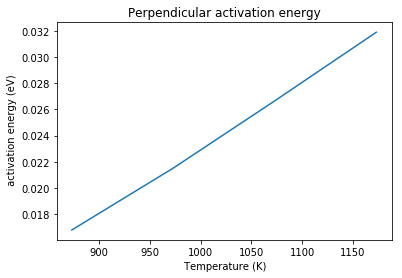

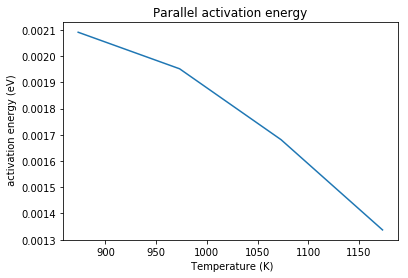

In [8]:
per_ea = calculate_activation_energies( per_resistivity_ratio_list, temp ) 
par_ea = calculate_activation_energies( par_resistivity_ratio_list, temp ) 

plt.plot( temp[1:-1], per_ea[1:-1] )
plt.title( 'Perpendicular activation energy')
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' activation energy (eV)' )
plt.show()

plt.plot( temp[1:-1], par_ea[1:-1] )
plt.title( 'Parallel activation energy')
plt.xlabel( ' Temperature (K)' )
plt.ylabel( ' activation energy (eV)' )
plt.show()